## Problem 1

For $\tau_w=0$, set $u = \hat{u} = 10$ [m/s] and $p = 0$ [Pa] everywhere as initial conditions.  These are the exact solutions to the mass and momentum equations for constant duct area.  Do one time step (using any time step size) and make sure that your code accepts this as the exact solution.  Repeat this problem with $u = \hat{u} = -10$ [m/s] to ensure that your code has no directional dependence.  Describe the boundary conditions used for the two cases, including the values of $\alpha_e$.

# Class definition

In [1]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [2]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP


In [3]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")


In [4]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs

import numpy

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, phi, phiold, rho, const, dt):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._phiold = phiold
        self._rho = rho
        self._const = const
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._const*self._grid.vol*(self._phi[1:-1]-self._phiold[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._const*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs


In [7]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)


In [17]:
class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1           
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [18]:
class AdvectingVelocityModel:
    """Class defining an advecting velocity model"""

    def __init__(self, grid, dhat, Uhe, P, U, coeffs):
        """Constructor"""
        self._grid = grid
        self._dhat = dhat
        self._Uhe = Uhe
        self._P = P
        self._U = U
        self._coeffs = coeffs

    def update(self):
        """Function to update the advecting velocity array"""

        # Calculate the pressure gradients across the faces
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        
        # Calculate the cell pressure gradients
        gradP = 0.5*(gradPw + gradPe)
          
        # Calculate damping coefficient, dhat
        Ve = 0.5*(self._grid.vol[0:-1] + self._grid.vol[1:])
        ae = 0.5*(self._coeffs.aP[0:-1] + self._coeffs.aP[1:])
        self._dhat[1:-1] = Ve/ae

        # Update the advecting velocity
        self._Uhe[0] = self._U[0]
        self._Uhe[1:-1] = 0.5*(self._U[1:-2] + self._U[2:-1]) - self._dhat[1:-1]*(gradPe[:-1] - 0.5*(gradP[:-1] + gradP[1:]))
        self._Uhe[-1] = self._U[-1]

In [19]:
class PressureForceModel:
    """Class defining a pressure force model"""

    def __init__(self, grid, P, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._P = P
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the pressure force
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        force = 0.5*(gradPw + gradPe)*self._grid.vol
          
        # Calculate the linearization coefficients
        coeffW = - 0.5*self._grid.vol/self._grid.dx_WP
        coeffE = 0.5*self._grid.vol/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(force)

        # Return the modified coefficient array
        return coeffs

In [20]:
class MassConservationEquation:
    """Class defining a mass conservation equation"""

    def __init__(self, grid, U, P, dhat, Uhe, rho, 
                 P_west_bc, P_east_bc, U_west_bc, U_east_bc):
        """Constructor"""
        self._grid = grid
        self._U = U
        self._P = P
        self._dhat = dhat
        self._Uhe = Uhe
        self._rho = rho
        self._P_west_bc = P_west_bc
        self._P_east_bc = P_east_bc
        self._U_west_bc = U_west_bc
        self._U_east_bc = U_east_bc

    def add(self, PP_coeffs, PU_coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the mass imbalance, based on advecting velocities
        imbalance = self._rho*self._grid.Ae*self._Uhe[1:] - self._rho*self._grid.Aw*self._Uhe[:-1]
              
        # Calculate the linearization coefficients on pressure
        PP_coeffW = np.concatenate((np.array([0]), -self._rho*self._grid.Aw[1:]*self._dhat[1:-1]/self._grid.dx_WP[1:]))
        PP_coeffE = np.concatenate((-self._rho*self._grid.Ae[:-1]*self._dhat[1:-1]/self._grid.dx_PE[:-1], np.array([0])))
        PP_coeffP = - PP_coeffW - PP_coeffE
        
        # Calculate the linearization coefficients on velocity
        PU_coeffW = np.concatenate((np.array([-self._rho*self._grid.Aw[0]]), -0.5*self._rho*self._grid.Aw[1:]))
        PU_coeffE = np.concatenate((0.5*self._rho*self._grid.Ae[:-1], np.array([self._rho*self._grid.Ae[-1]])))
        PU_coeffP = np.concatenate((np.array([0]), PU_coeffW[1:])) + np.concatenate((PU_coeffE[:-1], np.array([0])))

        # Modify the linearization coefficients on the boundaries 
        # (velocity only, since pressure is already zero)
        PU_coeffP[0] += PU_coeffW[0]*self._U_west_bc.coeff()
        PU_coeffP[-1] += PU_coeffE[-1]*self._U_east_bc.coeff()

        # Zero the boundary coefficients that are not used
        PU_coeffW[0] = 0.0
        PU_coeffE[-1] = 0.0

        # Add to coefficient arrays
        PP_coeffs.accumulate_aP(PP_coeffP)
        PP_coeffs.accumulate_aW(PP_coeffW)
        PP_coeffs.accumulate_aE(PP_coeffE)
        PP_coeffs.accumulate_rP(imbalance)
        PU_coeffs.accumulate_aP(PU_coeffP)
        PU_coeffs.accumulate_aW(PU_coeffW)
        PU_coeffs.accumulate_aE(PU_coeffE)

        # Return the modified coefficient arrays
        return PP_coeffs, PU_coeffs

In [21]:
class ExtrapolatedBc:
    """Class defining an extrapolated boundary condition"""

    def __init__(self, phi, grid, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - ((self._grid.dx_WP[0] / self._grid.dx_PE[0]) * (self._phi[2]-self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + ((self._grid.dx_PE[-1] / self._grid.dx_WP[-1]) * (self._phi[-2]-self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1 + (self._grid.dx_WP[0] / self._grid.dx_PE[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (1 + (self._grid.dx_PE[-1] / self._grid.dx_WP[-1]))
        else:
            raise ValueError("Unknown boundary location")

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            pass 
            self._phi[0] = self._phi[1] - ((self._grid.dx_WP[0] / self._grid.dx_PE[0]) * (self._phi[2]-self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            pass 
            self._phi[-1] = self._phi[-2] + ((self._grid.dx_PE[-1] / self._grid.dx_WP[-1]) * (self._phi[-2]-self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

# Solving the problem with $u = \hat{u} = 10$ [m/s]

In [27]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 4.0
ly = 0.02
lz = 0.02
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e9
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
mu = 1e-3

# Define the coefficients
PU_coeffs = ScalarCoeffs(grid.ncv)
PP_coeffs = ScalarCoeffs(grid.ncv)
UP_coeffs = ScalarCoeffs(grid.ncv)
UU_coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
U0 = 10
P0 = 0

# Initialize field variable arrays
U = U0*np.ones(grid.ncv+2)
P = P0*np.ones(grid.ncv+2)

# Initialize advecting velocity and damping coefficient array
dhat = np.zeros(grid.ncv+1)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions for velocity
U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

# Define boundary conditions for pressure
P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
U_west_bc.apply()
U_east_bc.apply()
P_west_bc.apply()
P_east_bc.apply()

# Define the transient model
Uold = np.copy(U)
transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

# Define the pressure force model
pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

# Define advecting velocity model
advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

# Define conservation of mass equation
mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                P_west_bc, P_east_bc, U_west_bc, U_east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" velocity field
    Uold[:] = U[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        
        # Zero all of the equations
        PP_coeffs.zero()
        PU_coeffs.zero()
        UU_coeffs.zero()
        UP_coeffs.zero()     
        
        # Assemble the momentum equations
        #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
        UU_coeffs = diffusion.add(UU_coeffs)
        UU_coeffs = advection.add(UU_coeffs)
        UU_coeffs = transient.add(UU_coeffs)
        UP_coeffs = pressure.add(UP_coeffs)
        
        # Assemble the mass equations
        advecting.update()
        PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

        # Compute residuals and check for convergence
        PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
        PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
        UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
        UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
        print("Iteration = {}.".format(i))
        print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
        print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
        if PmaxResid < converged and UmaxResid < converged:
            break
    
        # Solve the sparse matrix system
        dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)
    
        # Update the solutions 
        P[1:-1] += dP
        U[1:-1] += dU
        
        # Update boundary conditions
        U_west_bc.apply()
        U_east_bc.apply()
        P_west_bc.apply()
        P_east_bc.apply()
        
        # Update the advecting velocities
        advecting.update()
        
Velocity_positive = U
Pressure_positive = P
location_pos = grid.xP

Timestep = 0; Time = 1000000000.0
Iteration = 0.
  Mass:     Max. Resid. = 0.0; Avg. Resid. = 0.0
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
[0.  0.2 0.6 1.  1.4 1.8 2.2 2.6 3.  3.4 3.8 4. ]


# Solving the problem with $u = \hat{u} = -10$ [m/s]

In [28]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 4.0
ly = 0.02
lz = 0.02
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e9
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
mu = 1e-3

# Define the coefficients
PU_coeffs = ScalarCoeffs(grid.ncv)
PP_coeffs = ScalarCoeffs(grid.ncv)
UP_coeffs = ScalarCoeffs(grid.ncv)
UU_coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
U0 = -10
P0 = 0

# Initialize field variable arrays
U = U0*np.ones(grid.ncv+2)
P = P0*np.ones(grid.ncv+2)

# Initialize advecting velocity and damping coefficient array
dhat = np.zeros(grid.ncv+1)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions for velocity
U_west_bc = NeumannBc(U, grid, 0, BoundaryLocation.WEST)
U_east_bc = DirichletBc(U, grid, U0, BoundaryLocation.EAST)

# Define boundary conditions for pressure
P_west_bc = DirichletBc(P, grid, 0, BoundaryLocation.WEST)
P_east_bc = ExtrapolatedBc(P, grid, BoundaryLocation.EAST)

# Apply boundary conditions
U_west_bc.apply()
U_east_bc.apply()
P_west_bc.apply()
P_east_bc.apply()

# Define the transient model
Uold = np.copy(U)
transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

# Define the pressure force model
pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

# Define advecting velocity model
advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

# Define conservation of mass equation
mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                P_west_bc, P_east_bc, U_west_bc, U_east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" velocity field
    Uold[:] = U[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        
        # Zero all of the equations
        PP_coeffs.zero()
        PU_coeffs.zero()
        UU_coeffs.zero()
        UP_coeffs.zero()     
        
        # Assemble the momentum equations
        #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
        UU_coeffs = diffusion.add(UU_coeffs)
        UU_coeffs = advection.add(UU_coeffs)
        UU_coeffs = transient.add(UU_coeffs)
        UP_coeffs = pressure.add(UP_coeffs)
        
        # Assemble the mass equations
        advecting.update()
        PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

        # Compute residuals and check for convergence
        PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
        PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
        UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
        UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
        print("Iteration = {}.".format(i))
        print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
        print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
        if PmaxResid < converged and UmaxResid < converged:
            break
    
        # Solve the sparse matrix system
        dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)
    
        # Update the solutions 
        P[1:-1] += dP
        U[1:-1] += dU
        
        # Update boundary conditions
        U_west_bc.apply()
        U_east_bc.apply()
        P_west_bc.apply()
        P_east_bc.apply()
        
        # Update the advecting velocities
        advecting.update()
        
Velocity_negative = U
Pressure_negative = P
location_neg = grid.xP

Timestep = 0; Time = 1000000000.0
Iteration = 0.
  Mass:     Max. Resid. = 0.0; Avg. Resid. = 0.0
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0


# Plotting the results

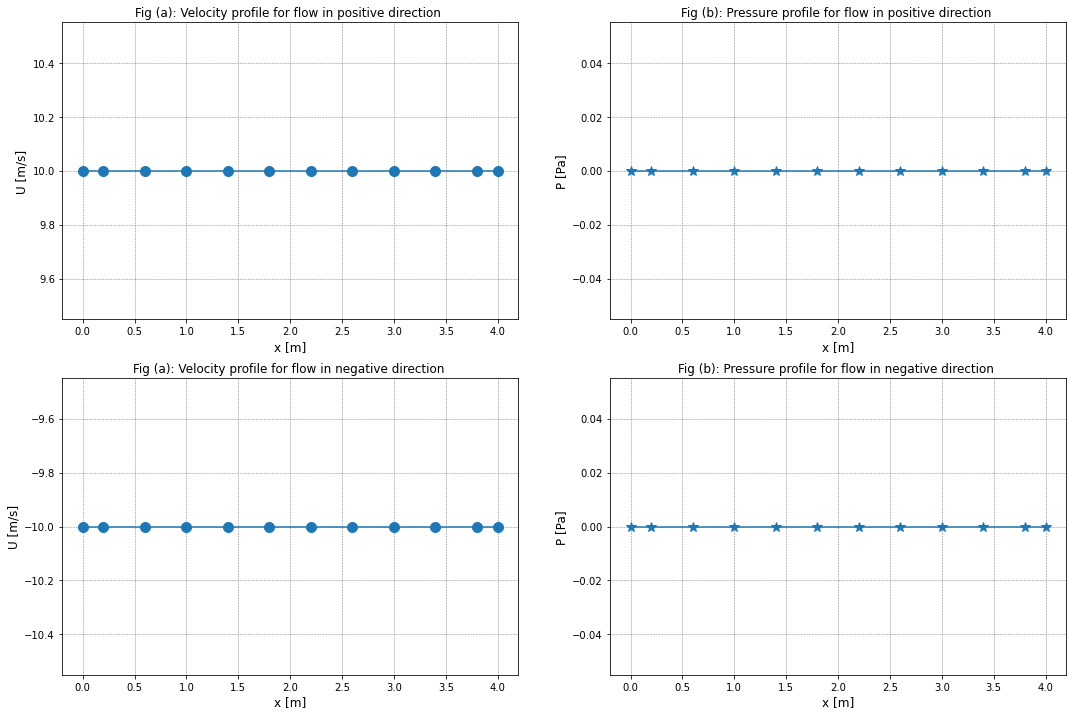

In [32]:
""" Plot of results for flow in positive & negative direction """
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(18,12))
axes1 = fig.add_subplot(2,2,1)
axes2 = fig.add_subplot(2,2,2)
axes3 = fig.add_subplot(2,2,3)
axes4 = fig.add_subplot(2,2,4)

axes1.plot(location_pos, Velocity_positive, marker = "o",markersize=10,)
axes1.set_xlabel('x [m]',fontsize = 12)
axes1.set_ylabel('U [m/s]',fontsize = 12)
axes1.set_title('Fig (a): Velocity profile for flow in positive direction ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

axes2.plot(location_pos, Pressure_positive, marker = "*",markersize=10,)
axes2.set_xlabel('x [m]',fontsize = 12)
axes2.set_ylabel('P [Pa]',fontsize = 12)
axes2.set_title('Fig (b): Pressure profile for flow in positive direction ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

axes3.plot(location_neg, Velocity_negative, marker = "o",markersize=10,)
axes3.set_xlabel('x [m]',fontsize = 12)
axes3.set_ylabel('U [m/s]',fontsize = 12)
axes3.set_title('Fig (a): Velocity profile for flow in negative direction ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

axes4.plot(location_neg, Pressure_negative, marker = "*",markersize=10,)
axes4.set_xlabel('x [m]',fontsize = 12)
axes4.set_ylabel('P [Pa]',fontsize = 12)
axes4.set_title('Fig (b): Pressure profile for flow in negative direction ',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)



# Comments

Exact soln tai residual 0
And code has no directional dependence sheta bujhanor jonno U = -10 jokhon diechi tokhon U and P er boundar conditions o flip kore diechi.
Likho j u = 10 er jonno alpahe keno+ve and -10 er jnno keno -ve (all)
